# Runtime Test

In [34]:
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

import numpy as np

from descriptor_utils import DescriptorWrapper
from tqdm import tqdm
import pandas as pd
import time
import samp as smp
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
data = np.load("point_clouds/all_point_clouds.npz", allow_pickle=True)
point_clouds = data['objects']
labels = data['labels']

In [17]:
# duplicate 10 times
for i in range(3):
    point_clouds = np.concatenate((point_clouds, point_clouds))

In [18]:
descriptor_wrapper = DescriptorWrapper()

descriptors = ['evrap', 'sirm', 'scomp', 'sector_model', 'shell_model', 'combined_model', 'fpfh']
runtime_data = {**{descriptor: [] for descriptor in descriptors}, **{'samp': [], 'combination': [], 'dataset_size': []}}

In [19]:
progress_bar = tqdm(range(200, 1500, 100), desc="")
for test_size in progress_bar:
    test_data = point_clouds[:test_size]
    runtime_data['dataset_size'].append(len(test_data))
    for descriptor in descriptors:
        progress_bar.set_description(descriptor)
        start_time = time.perf_counter()
        descriptor_wrapper.compute_model_on_dataset(test_data, descriptor)
        runtime_data[descriptor].append(time.perf_counter() - start_time)
    progress_bar.set_description('samp')
    start_time = time.perf_counter()
    smp.compute_samp_on_dataset(test_data)
    runtime_data['samp'].append(time.perf_counter() - start_time)
    
    runtime_data['combination'].append(sum(runtime_data[key][-1] for key in ['evrap', 'sirm', 'scomp', 'evrap']))

samp:   0%|          | 0/13 [00:15<?, ?it/s]          /home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
samp:   8%|▊         | 1/13 [01:08<09:05, 45.43s/it]          /home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
samp:  15%|█▌        | 2/13 [02:30<11:20, 61.86s/it]          /home/nico/miniconda3/envs/p1-repository/lib/python3.8/sit

In [24]:
runtime_df = pd.DataFrame(runtime_data)
runtime_df['combination'] = runtime_df[['evrap', 'samp', 'scomp', 'sirm']].sum(axis=1)

In [31]:
runtime_df.to_csv('test_output/runtime_data.csv')

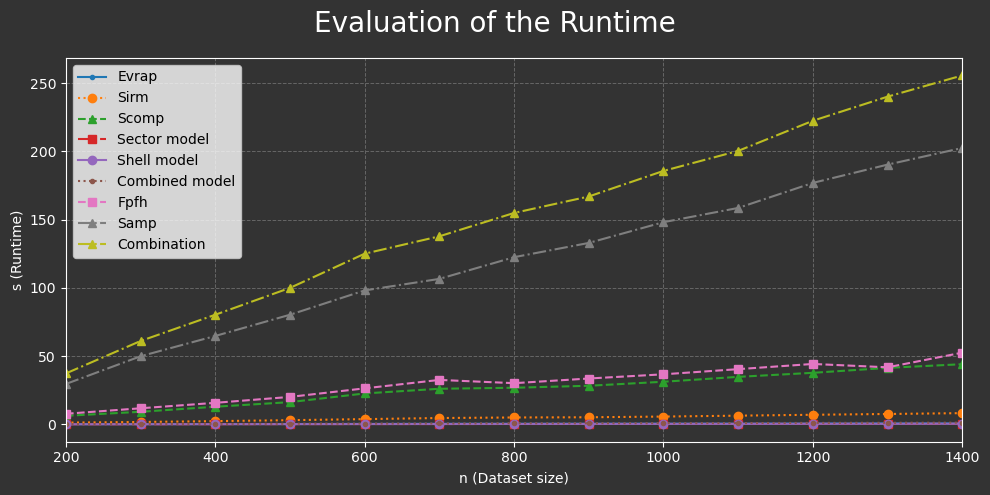

In [43]:
linestyles = [('.', 'solid'), ('o', 'dotted'), ('^', 'dashed'), ('s', 'dashdot'), ('o', 'solid'), ('.', 'dotted'),
              ('s', 'dashed'), ('^', 'dashdot')]

fig, ax = plt.subplots(figsize=(10, 5))
# Plotting
for index, descriptor in enumerate(runtime_data.keys()):
    if descriptor != 'dataset_size':
        legend_label = descriptor.replace("_", " ").capitalize()
    
        linestyle = linestyles[index % len(linestyles)]
        ax.plot(runtime_df['dataset_size'], runtime_df[descriptor],
                label=legend_label, linestyle=linestyle[1],
                marker=linestyle[0])

legend_label = 'Combination'
linestyle = linestyles[len(linestyles) - 1]
ax.plot(runtime_df['dataset_size'], runtime_df['combination'],
        label=legend_label, linestyle=linestyle[1],
        marker=linestyle[0])

ax.set_xlabel("n (Dataset size)", color='white')
ax.set_ylabel("s (Runtime)", color='white')
ax.legend()
ax.grid(True)

ax.set_facecolor('#333333')  # Dark grey background for the plot area

# Customize ticks and labels
ax.tick_params(colors='white')  # White ticks
ax.xaxis.label.set_color('white')  # X-axis label color
ax.yaxis.label.set_color('white')  # Y-axis label color

ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

ax.set_xlim(np.min(runtime_df['dataset_size']), np.max(runtime_df['dataset_size']))

# Customize grid
ax.grid(color='#666666', linestyle='--', linewidth=0.7)

fig.suptitle("Evaluation of the Runtime", color="white", fontsize=20)
fig.patch.set_facecolor('#333333')  # Dark grey background for the figure
fig.tight_layout()

plt.show()